In [23]:
source("./preprocess/utils.R")
setwd("./")
library(mclust)
library(RColorBrewer)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "atlas_tissues_cl")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "c_3")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--reference", type = "character", default = "atlas_new")
parser$add_argument("--init_model", type = "character", default = "")
o <- parser$parse_known_args()[[1]]

config <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$task)]]
config_ref <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$reference)]]
config$raw_data_dirs <- c(config_ref$raw_data_dirs, config$raw_data_dirs)
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$reference)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$model, o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat_cca", "l1.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

In [2]:
z_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir    <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)

    if (i < 35) {
        cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
            "cell_names.csv"), header = T)[, 2]    
    } else if (i == 35) {
        cell_name_list[[subset_name]] <- read.csv(pj(pj("data", "processed", "tonsil"), paste0("subset_", '0'),
            "cell_names.csv"), header = T)[, 2]
    } else if (i == 36) {
        cell_name_list[[subset_name]] <- read.csv(pj(pj("data", "processed", "bone_marrow_02"), paste0("subset_", '0'),
            "cell_names.csv"), header = T)[, 2]
    } else if (i == 37) {
        cell_name_list[[subset_name]] <- read.csv(pj(pj("data", "processed", "spleen"), paste0("subset_", '0'),
            "cell_names.csv"), header = T)[, 2]
    }
    if (file.exists(label_paths[i])) {
        if (grepl('lane', subset_names[i])) {
            label_list[[subset_name]] <- read.csv(gsub("l1.csv", "l1_singler.csv", label_paths[i]), header = T)[, 2]
        } else {
            label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
        }
    } else {
        is_label <- F
    }
    
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/37, File 1/29

Loading Subset 1/37, File 2/29

Loading Subset 1/37, File 3/29

Loading Subset 1/37, File 4/29

Loading Subset 1/37, File 5/29

Loading Subset 1/37, File 6/29

Loading Subset 1/37, File 7/29

Loading Subset 1/37, File 8/29

Loading Subset 1/37, File 9/29

Loading Subset 1/37, File 10/29

Loading Subset 1/37, File 11/29

Loading Subset 1/37, File 12/29

Loading Subset 1/37, File 13/29

Loading Subset 1/37, File 14/29

Loading Subset 1/37, File 15/29

Loading Subset 1/37, File 16/29

Loading Subset 1/37, File 17/29

Loading Subset 1/37, File 18/29

Loading Subset 1/37, File 19/29

Loading Subset 1/37, File 20/29

Loading Subset 1/37, File 21/29

Loading Subset 1/37, File 22/29

Loading Subset 1/37, File 23/29

Loading Subset 1/37, File 24/29

Loading Subset 1/37, File 25/29

Loading Subset 1/37, File 26/29

Loading Subset 1/37, File 27/29

Loading Subset 1/37, File 28/29

Loading Subset 1/37, File 29/29

Loading Subset 2/37, File 1/24

Loading Subset 2/37,

In [ ]:
# Create seurat object
rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
obj <- CreateSeuratObject(counts = rna, assay = "rna")

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

obj

In [ ]:
# Generate UMAP for visualization
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)
# obj <- LoadH5Seurat(pj(output_dir, "obj.h5seurat"), reductions = "c.umap")

In [25]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[35:37]

cell_label <- gsub(" cell", "", read.csv(pj(output_dir, "label_gt.csv"), header = F)[, 1])
obj@meta.data$highlight[select_mask] <- cell_label

# Set colors
cell_label_unique <- unique(cell_label)
labels <- str_sort(cell_label_unique)

col_8 <- c("#8FC36D", "#f54646", "#4472c4", "#5d00ff", "#ff69b4", "#0077ff", "#fff300", "#008000", "#ad6800", "#0000ff")

pal <- col_8
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")


# plot
p1 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 0.1, 
              shuffle = F, cols = cols, legend = T, return_plt = T, save_path = pj(output_dir, paste(o$task,
              o$method, o$experiment, o$model, o$init_model, "c_merged_label_l1", sep = "_"))) +
    labs(colour = "Seurat cell type")

In [26]:
cell_label <- gsub(" cells", "", read.csv(pj(output_dir, "label_transferred.csv"), header = F)[, 1])
obj@meta.data$highlight[select_mask] <- cell_label

# Set colors
cell_label_unique <- unique(cell_label)
labels <- str_sort(cell_label_unique)

col_13 <- c("#8FC36D", "#f54646", "#ff00ff", "#4472c4", "#82B4ed",  "#ff69b4", "#14e6e6", "#D4aaff", "#fff300", "#008000", "#eee8aa", "#2f4f4f", "#ad6800")

pal <- c(col_13, "#0000ff")
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")

# plot
p2 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 0.1, 
              shuffle = F, cols = cols, legend = T, return_plt = T, save_path = pj(output_dir, paste(o$task,
              o$method, o$experiment, o$model, o$init_model, "c_merged_label_transfer", sep = "_"))) +
    labs(colour = "MIRACLE cell type")

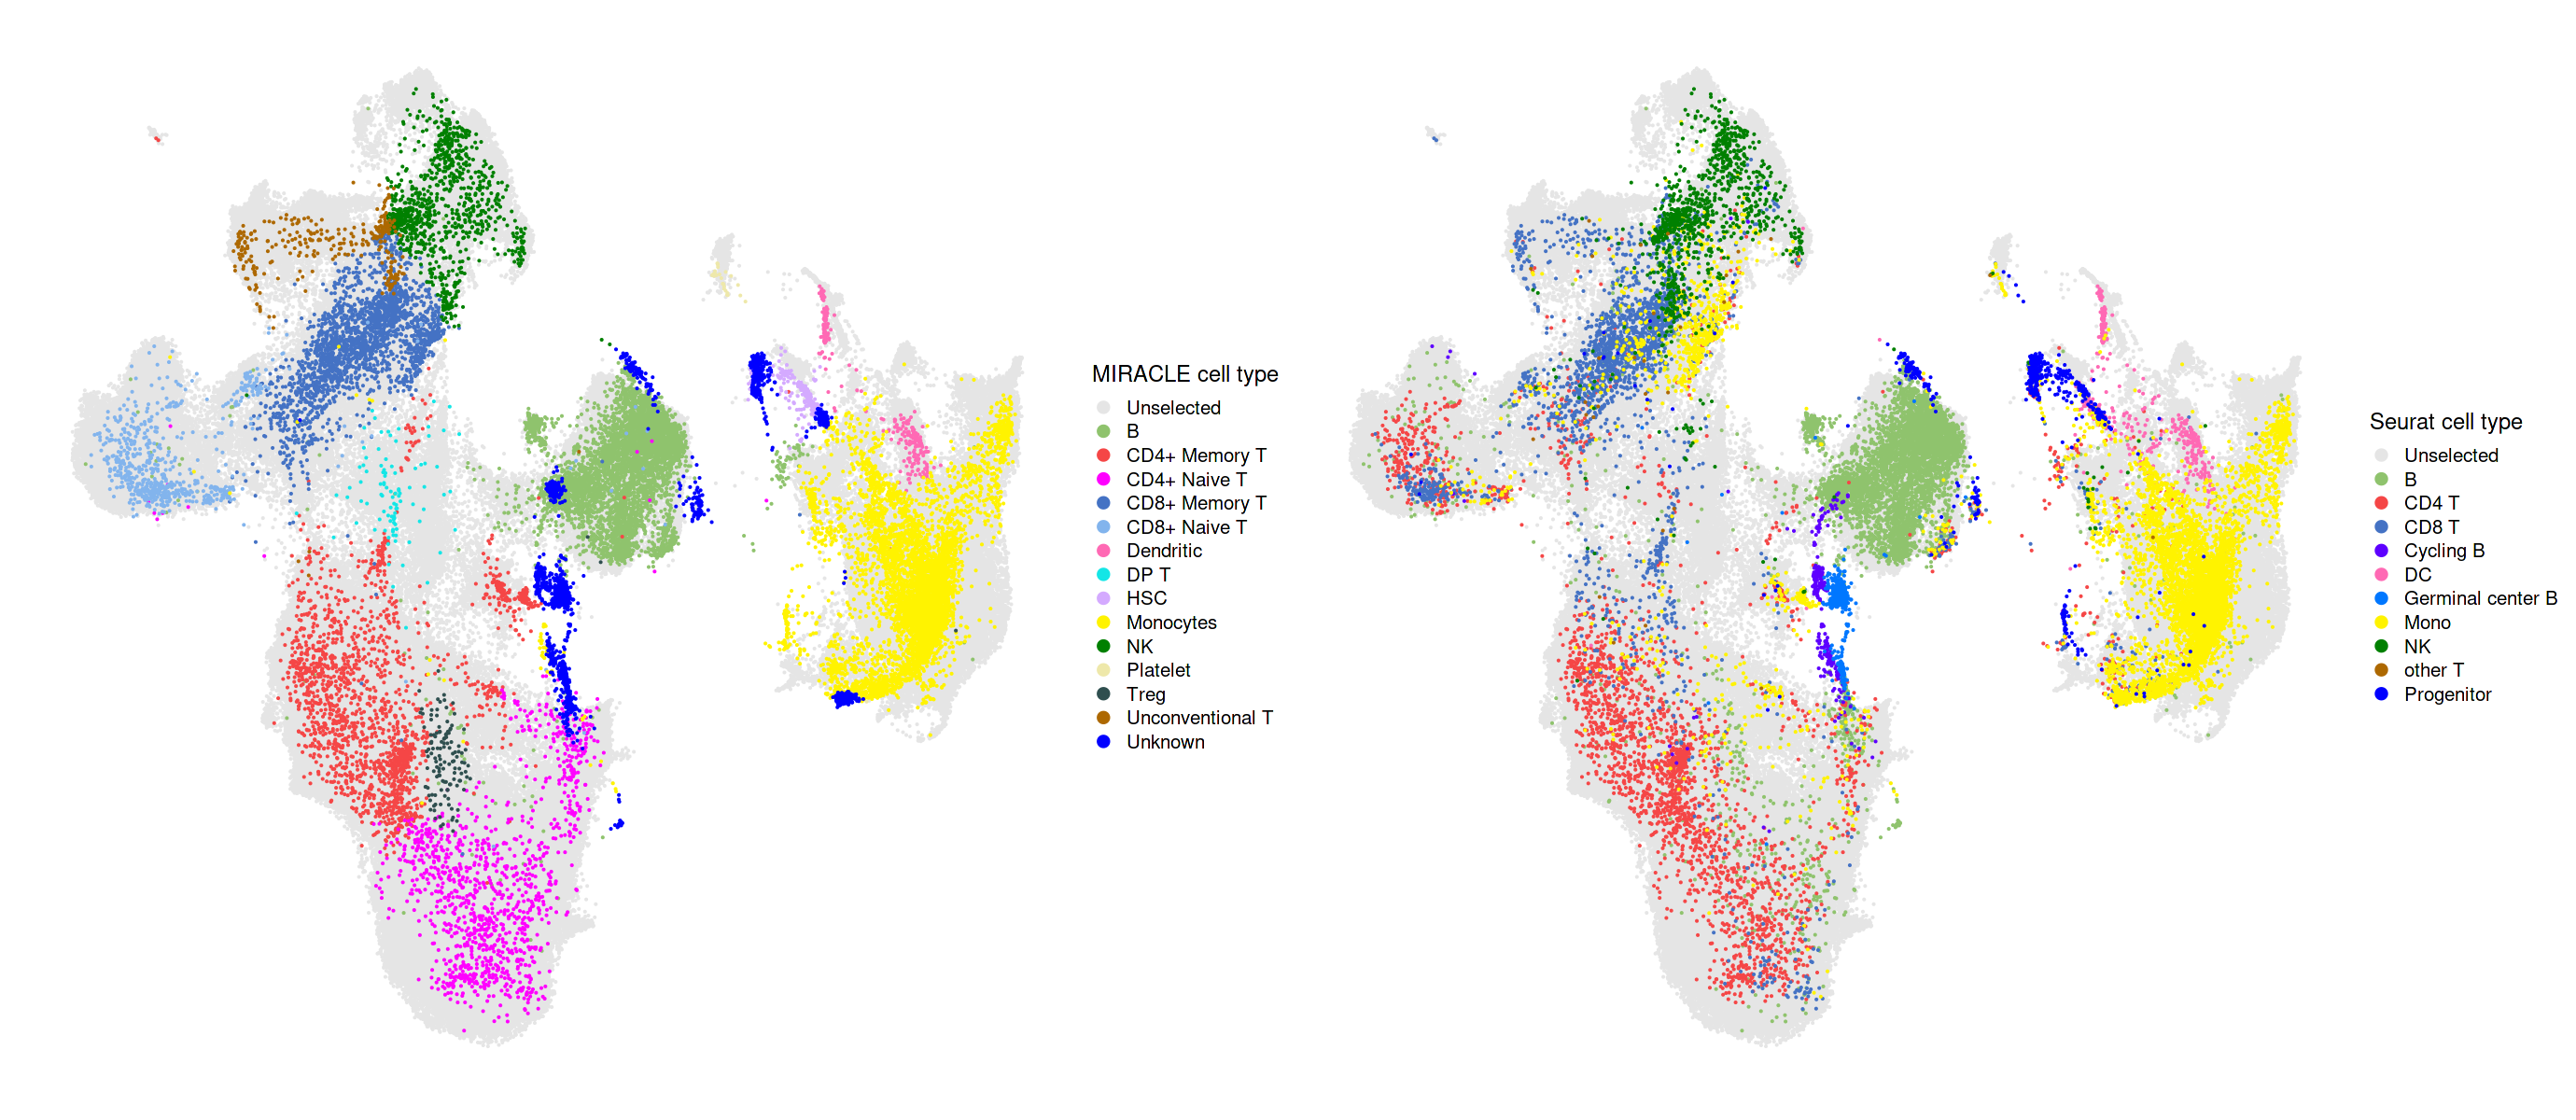

In [14]:
w = 2 * (L + 1.5)
h = L
plt_size(w, h)
plt <- p2 | p1 
plt

In [31]:
save_dir <- "./analysis/fig"
mkdir(save_dir, remove_old = F)
ggsave(plot = plt, file = pj(save_dir, "label_transfer_tissues_umap.png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = pj(save_dir, "label_transfer_tissues_umap.pdf"), width = w, height = h, limitsize = F)